# Introduction to stochastic variational inference in pyro

## Inferring coin bias with the beta-binomial model

In [1]:
import numpy as np
import pyro.distributions as dist
import pyro
from torch.distributions import constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch

In [2]:
from tqdm import tqdm

In [3]:
import arviz as az
import matplotlib.pyplot as plt

Specify the joint density 

In [4]:
def model(data):    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])  # Don't worry, we will vectorize this later

Specify the variational family

In [5]:
def guide(data):  # guide and model must have the same signature, despite us not actually using the data in this case
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), # optimization initialization
                         constraint=constraints.positive, # constrained optimization
                        )  # requires_grad is automatically set to True
    beta_q = pyro.param("beta_q", torch.tensor(15.0), 
                        constraint=constraints.positive)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

Specify optimizer

In [6]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [7]:
d = torch.tensor(np.random.binomial(n=1, p=0.55, size=10), dtype=float)

In [8]:
n_steps = 1000

for step in tqdm(range(n_steps)):
    svi.step(d)

100%|██████████| 1000/1000 [00:04<00:00, 229.46it/s]


Grab the learned variational parameters

In [9]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [10]:
def summarize_beta(alpha, beta):
    inferred_mean = alpha / (alpha + beta)
    
    factor = beta / (alpha * (1.0 + alpha + beta))
    inferred_std = inferred_mean * np.sqrt(factor)
    return inferred_mean, inferred_std

In [11]:
summarize_beta(alpha_q, beta_q)

(0.4982493600079228, 0.08982133751085475)

## Conditional independence and subsampling

The objective is to not have to touch every data point during inference, but rather approximate the log likelihood with mini-batches. Let $\boldsymbol{x}$ denote a data vector of observations, and $\boldsymbol{z}$ denote a vector of latent random variables 

$$\sum_{i=1}^N \log p(\boldsymbol{x}_i | \boldsymbol{z}) \approx \frac{N}{M} \sum_{i \in \mathcal{I}_M}^N \log p(\boldsymbol{x}_i | \boldsymbol{z})$$

where $\mathcal{I}_M$ is a mini-batch of indices of size $M$. To do this, we require the variational family to be a **conditionally conjugate model**, see [Blei's review](https://arxiv.org/pdf/1601.00670.pdf).

The `pyro.plate` allows us to encode conditional independence in the model. Let's do that:

In [12]:
def model_vec(data):    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])  # this allows us to leverage conditional independence of the observations given the latent variables

Let's make this more efficient by:
- Vectorizing 
- Subsampling, so we can mini-batch

In [13]:
def model_vec_subsampled(data):    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    with pyro.plate("observe_data", 
                    
                    # Size is required so that the correct scaling factor can be computed
                    size=len(data), 
                    
                    # We only evaluate the log likelihood for 5 randomly chosen datapoints in the data, 
                    # and the log likelihood will automatically get scaled by N/M
                    subsample_size=5,  
                                    
                    # set the device to use a GPU
                    # device = 
                    
                    # A stateful subsampling scheme may be necessary -- it is possible to never touch 
                    # some data points if the dataset is sufficiently large
                    # subsample = 
                   ) as ind:
        pyro.sample("obs", dist.Bernoulli(f), obs=data.index_select(0, ind))  # this will be a tensor of length 5  

In [14]:
svi = SVI(model_vec_subsampled, guide, optimizer, loss=Trace_ELBO())

In [15]:
n_steps = 1000

for step in tqdm(range(n_steps)):
    svi.step(d)

100%|██████████| 1000/1000 [00:01<00:00, 514.65it/s]


In [16]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [17]:
summarize_beta(alpha_q, beta_q)

(0.4968436189845653, 0.08969412420564438)

## Conditionally conjugate models

We may also have conditional independence in the variational distribution (the `guide`) too.

Let $\beta$ be a vector of global latent variables, which potentially govern any of the data. Let $z$ be a vector of local latent variables, whose $i$th component only governs data in the $i$th "context". The joint density of a conditionally conjugate model is:

$$p(\beta, \boldsymbol{z}, \boldsymbol{x}) = p(\beta) \prod_{i=1}^n p(z_i, x_i | \beta)$$

The variational family (according to the pyro docs, though I don't yet get how this gels with the review) should factorize like

$$p(\beta, \boldsymbol{z}) = p(\beta) \prod_{i=1}^n p(z_i | \beta, \lambda_i)$$

where $\lambda_i$ are local variational parameters (other variational parameters are left implicit). 

Consider a mixture of Gaussians model

$$\mu_k \sim N(0, \sigma^2), k=1,...,K$$
$$c_i \sim \text{Cat}(1/K, ..., 1/K), i=1,...,n$$
$$x_i|c_i,\mu \sim \mathcal{N}(c_i^T \mu, 1), i=1,...,n$$

(see also [this example](https://pyro.ai/examples/gmm.html))

We choose a mean-field variational family of the form

$$q(\mu, c) = \prod_{k=1}^K q(\mu_k; m_k, s^2_k) \prod_{i=1}^n q(c_i; \phi_i)$$

where we seek to optimize $m_k, s^2_k, \phi_i$. In this case, 

$$q(\mu_k; m_k, s^2_k) = \mathcal{N}(m_k, s^2_k) $$

$$q(c_i; \phi_i) = \phi_i$$

where $\phi_i$ is a K-vector of probabilities.

In [18]:
np.random.seed(42)

K = 2
n = 100
sigma_mu = 10.
mu_k = np.random.normal(0, sigma_mu, size=K)
ci = np.random.choice(K, size=n)
sigma = 1
d = []
for i, c in enumerate(ci):
    d.append(np.random.normal(mu_k[c], sigma))
d = np.hstack(d)

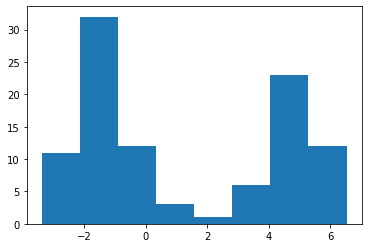

In [19]:
plt.hist(d, bins='auto');

In [20]:
from pyro.infer import config_enumerate

In [21]:
@config_enumerate
def model_mixture_of_gaussians(data):
    weights = torch.ones(K, dtype=float)/K
    
    with pyro.plate("mu", K):
        locs = pyro.sample("locs", dist.Normal(0., sigma_mu))
        
    with pyro.plate("data", len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights)).to(torch.int64)
        pyro.sample('obs', dist.Normal(locs[assignment], 1.), obs=data)
    

In [22]:
@config_enumerate
def guide_mixture_of_gaussians(data):
    with pyro.plate("mu", K):        
        m_k = pyro.param("m", torch.tensor(0.))
        s_k = pyro.param("s", torch.tensor(10.), constraint=constraints.positive)
        pyro.sample("locs", dist.Normal(m_k, s_k))
    
    with pyro.plate("data", len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data))/K, constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs))

In [23]:
svi = SVI(model_mixture_of_gaussians, guide_mixture_of_gaussians, optimizer, loss=Trace_ELBO())

In [30]:
n_steps = 1000
losses = []
d_tensor = torch.tensor(d)
for step in tqdm(range(n_steps)):    
    losses.append(svi.step(d_tensor))

100%|██████████| 1000/1000 [00:02<00:00, 368.47it/s]


In [25]:
pyro.param('m')

tensor(0.0976, requires_grad=True)

In [26]:
pyro.param('s')

tensor(7.2763, grad_fn=<AddBackward0>)

In [27]:
pyro.param("assignment_probs")

tensor([0.4996, 0.4984, 0.4988, 0.5005, 0.5026, 0.5000, 0.5013, 0.5031, 0.5033,
        0.4990, 0.5035, 0.4916, 0.5062, 0.5051, 0.4990, 0.5001, 0.5048, 0.5018,
        0.5042, 0.5019, 0.5036, 0.5051, 0.5002, 0.5067, 0.4987, 0.5030, 0.5020,
        0.5043, 0.5051, 0.5020, 0.4969, 0.5025, 0.5037, 0.5012, 0.5032, 0.5004,
        0.4988, 0.5013, 0.5030, 0.5070, 0.5015, 0.5052, 0.4970, 0.5019, 0.5006,
        0.4949, 0.5014, 0.5069, 0.4982, 0.5030, 0.4976, 0.5048, 0.5047, 0.5024,
        0.4950, 0.5003, 0.4957, 0.4987, 0.4953, 0.5047, 0.5031, 0.5049, 0.4997,
        0.5003, 0.5043, 0.5018, 0.4968, 0.4997, 0.4989, 0.5031, 0.5020, 0.5021,
        0.4988, 0.5072, 0.4977, 0.5007, 0.5063, 0.5008, 0.5021, 0.4993, 0.5035,
        0.4965, 0.4973, 0.5011, 0.4978, 0.5035, 0.5029, 0.5016, 0.5034, 0.5014,
        0.5012, 0.5003, 0.5070, 0.5047, 0.5070, 0.5054, 0.5051, 0.4997, 0.5071,
        0.5084], grad_fn=<ClampBackward1>)

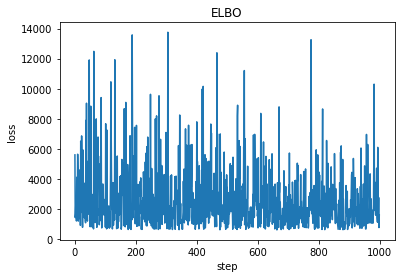

In [31]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss");

## Amortization

In [28]:
# TODO